# 10 Approximate Inference

## 10.1.3 Example: The univariate Gaussian 

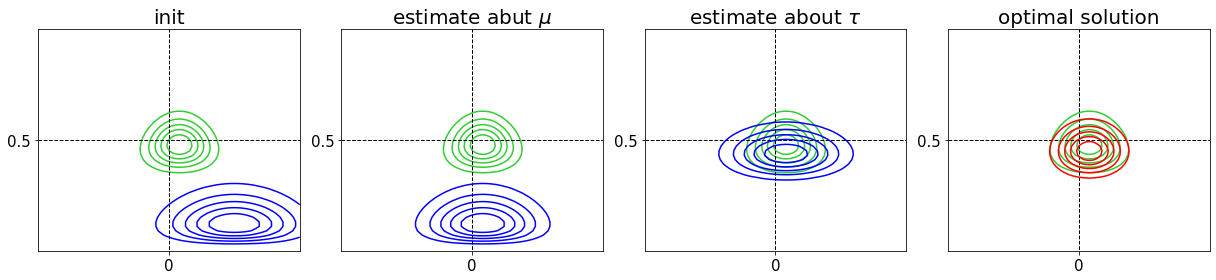

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pd import *
from scipy.stats import norm, gamma


def pred(mu, tau, params):
    Norm = norm.pdf(mu, params[0], np.sqrt(1 / params[1]))
    Gamma = gamma.pdf(tau, a=params[2], scale= 1 / params[3])
    return Norm * Gamma

true_mu = 0
true_tau = 0.5


# preparing training data
X_train = np.random.normal(true_mu, np.sqrt(1. / true_tau), 75)
mu_test, lam_test = np.meshgrid(np.linspace(-1,1,100), np.linspace(0.01,2,100))


'''Variational estimation'''
model = VariationalGaussian(*[.5, 10, 4, 25])
model.fit(X_train)
pdf = model.pdf(mu_test.ravel(), lam_test.ravel())


fig = plt.figure(figsize = (17, 4))
n_step = len(model.history) // 2
keys = [
        model.history['tauStep1'],
        model.history['muStep2'],
        model.history['tauStep2'],
        model.history['tauStep' + str(n_step)]
        ]
c = ['b', 'b', 'b', 'r']
text = ['init', 'estimate abut $\mu$', r'estimate about $\tau$', 'optimal solution']
for n, key in enumerate(keys):
    ax = fig.add_subplot(1, 4, n+1)
    ax.contour(mu_test, lam_test, pdf.reshape(mu_test.shape), levels=np.linspace(min(pdf), max(pdf), 7), colors='limegreen')
    plt.xticks([0], fontsize=15)
    plt.yticks([0.5], fontsize=15)
    plt.ylim(0,1)
    plt.hlines(y=true_tau, xmin=-1, xmax=1, linewidth=1, linestyle='--', color = 'k')
    plt.vlines(x=true_mu, ymin=-1, ymax=1, linewidth=1, linestyle='--', color = 'k')
    Z = pred(mu_test.ravel(), lam_test.ravel(), key)
    ax.contour(mu_test, lam_test, Z.reshape(mu_test.shape), levels=np.linspace(min(Z), max(Z), 7), colors=c[n])
    plt.title(text[n], fontsize=20)
plt.tight_layout()
plt.show()

## 10.2. Illustration: Variational Mixture of Gaussians

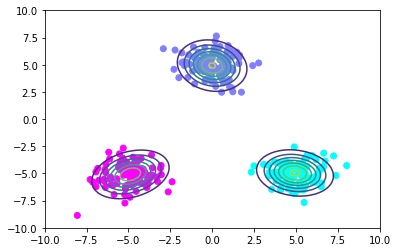

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pd import *


def make_blobs():
    cls1 = np.random.normal(size=(100, 2), loc=(-5,-5))
    cls2 = np.random.normal(size=(100, 2), loc=(5, -5))
    cls3 = np.random.normal(size=(100, 2), loc=(0, 5))
    return np.vstack((cls1, cls2, cls3))


# training & test data
X_train = make_blobs()
x_test, y_test = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
X_test = np.array([x_test, y_test]).reshape(2, -1).T


''' variational reasoning '''
vbgm = BayesianGaussianMixture(n_components=10, alpha_0=0.01)
vbgm.fit(X_train)
Z = vbgm.predict(X_test)


plt.contour(x_test, y_test, Z.reshape(x_test.shape))
plt.scatter(X_train[:, 0], X_train[:, 1], cmap='cool', c=vbgm.classify(X_train))
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

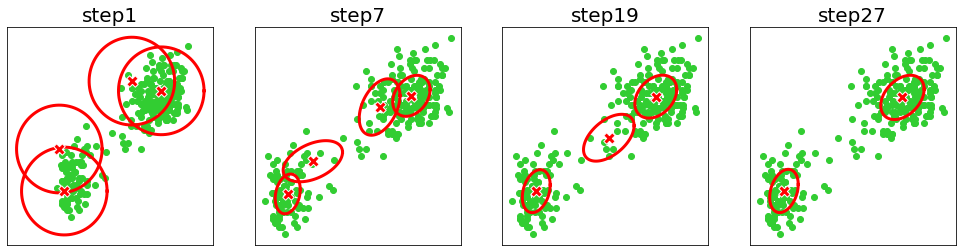

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from deepL_module.datasets import *
from deepL_module.base import *
from pd import *


def ellipse_draw(ax, mu, var):
    for center, cov in zip(mu, var):
        X, Y = ellipse2D_orbit(center, cov).T
        ax.plot(X, Y, color='r', linewidth=3)


# training data & test data
X_train = load_faithful(normalize=True)
x_test, y_test = np.meshgrid(np.linspace(0, 6, 100), np.linspace(0, 100, 100))
X_test = np.array([x_test, y_test]).reshape(2, -1).T


''' Variational Gaussian Mixture '''
model = BayesianGaussianMixture(n_components=4, alpha_0=1e-2)
model.fit(X_train, n_iter=100)
labels = model.classify(X_train)
Z = model.predict(X_test)



fig = plt.figure(figsize=(17,4))
keys = list(model.eff_params.keys())
n_step = len(keys)
keys = [keys[0], keys[n_step // 4], keys[2 * n_step // 3], keys[-1]]
for n, key in enumerate(keys):
    ax_ = fig.add_subplot(1, len(keys), n+1)
    ax_.scatter(*X_train.T, c='limegreen')
    ax_.scatter(*model.eff_params[key]['means'].T, s=130, marker='X', lw=1, c='r', edgecolor="white", zorder=3)
    ellipse_draw(ax_, model.eff_params[key]['means'], model.eff_params[key]['covs'])
    ax_.set_title(str(key), fontsize=20)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.tick_params(bottom=False, left=False)
plt.show()

## 10.3. Variational Linear Regression

## 10.3.2 Predictive distribution

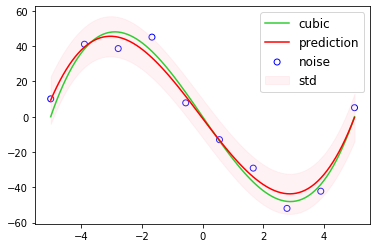

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from base_module import Poly_Feature
from fitting import *

def generate_noise_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def cubic(x):
    return x * (x - 5) * (x + 5)

# training data & test data
feature = Poly_Feature(degree=3)
train_x, train_t = generate_noise_data(cubic, 10, 10, [-5, 5])
X_train = feature.transform(train_x)

x = np.linspace(-5, 5, 100)
X_test = feature.transform(x)

'''Variational Linear Regression'''
model = VariationalRegressor(beta=1e-2, a0=1, b0=1)
model.fit(X_train, train_t)
y_mean, y_std = model.predict(X_test, get_std=True)


plt.scatter(train_x, train_t, facecolor="none", edgecolor='b', label='noise')
plt.plot(x, cubic(x), c="limegreen", label="cubic")
plt.plot(x, y_mean, c="r", label="prediction")
plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color="pink", label='std')
plt.legend(fontsize=12)
plt.show()

## 10.3.3 Lower bound

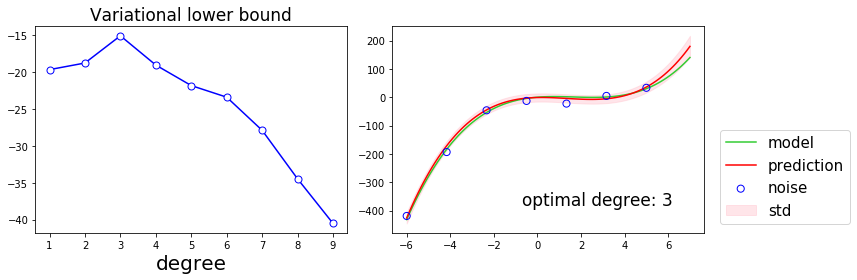

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from base_module import Poly_Feature
from fitting import *

max_deg = 9

def generate_noise_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t


def func(x):
    return  x * (x - 2) * (x - 3)


# training data & test data
train_x, train_t = generate_noise_data(func, 7, 10, [-6, 5])
x = np.linspace(-6, 7, 100)


'''Variational lower bound'''
L_list = []
models = []
for m in range(1, max_deg + 1):
    model = VariationalRegressor(beta=5e-3, a0=1, b0=1)
    X_train = Poly_Feature(m).transform(train_x)
    model.fit(X_train, train_t)
    l_bound = model.lower_bound()
    L_list.append(l_bound)
    models.append(model)


L_list = np.array(L_list)
idx = np.argmax(L_list)

# plot lower bound
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.plot(np.arange(1, max_deg + 1), L_list, color='b', marker='o', markeredgecolor='b', markerfacecolor='w', markersize=7)
plt.xlabel("degree", fontsize=20)
plt.title('Variational lower bound',fontsize=17)


# plot training data
ax = fig.add_subplot(122)
ax.scatter(train_x, train_t, facecolor="none", edgecolor='b', label='noise',s=50, zorder=3)
ax.plot(x, func(x), color='limegreen', label='model')


# plot optimal prediction
X_test = Poly_Feature(idx+1).transform(x)
y_mean, y_std = models[idx].predict(X_test, get_std=True)

plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.4, color="pink", label='std')
ax.text(0.9,0.2,"optimal degree: {}".format(idx+1),ha='right',va='top', transform=ax.transAxes, fontsize=17)
plt.plot(x, y_mean, c="r", label="prediction")
ax.legend(bbox_to_anchor=(1.05,0.5),loc='upper left',borderaxespad=0,fontsize=15)
plt.tight_layout()
plt.show()

## 10.5. Local Variational Methods

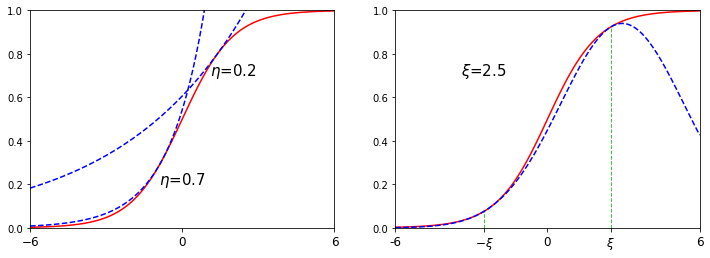

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from deepL_module.base import *

def g(eta):
    return -eta * np.log(eta) - (1 - eta) * np.log(1 - eta)

def upper(x, eta):
    return np.exp(eta * x - g(eta))

def lamb(x):
    return 0.5 * (sigmoid(x) - 0.5) / x

def lower(x, xi):
    return sigmoid(xi) * np.exp(0.5 * (x - xi) - lamb(xi) * (x ** 2 - xi ** 2))


x = np.linspace(-6, 6, 100)


fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
ax.plot(x, sigmoid(x), c='r')
ax.plot(x, upper(x, eta=0.2), c='b', ls='dashed')
ax.plot(x, upper(x, eta=0.7), c='b', ls='dashed')
plt.text(0, .2, r"$\eta$=0.7" ,fontsize=15, ha='center')
plt.text(2, .7, r"$\eta$=0.2" ,fontsize=15, ha='center')
plt.xticks([-6, 0, 6], fontsize=12)
plt.xlim(-6, 6)
plt.ylim(0, 1)


ax = fig.add_subplot(122)
ax.plot(x, sigmoid(x), c='r')
ax.plot(x, lower(x, xi=2.5), c='b', ls='dashed')
ax.vlines(x=-2.5, ymin=0, ymax=sigmoid(-2.5), lw=1, ls='--', color='limegreen')
ax.vlines(x= 2.5, ymin=0, ymax=sigmoid( 2.5), lw=1, ls='--', color='limegreen')
plt.xticks([-6, -2.5, 0, 2.5, 6],("-6", r"$-\xi$" ,"0", r"$\xi$", "6"), fontsize=12)
plt.text(-2.5, .7, r"$\xi$=2.5", fontsize=15, ha='center')
plt.xlim(-6, 6)
plt.ylim(0, 1)

plt.show()

## 10.6. Variational Logistic Regression

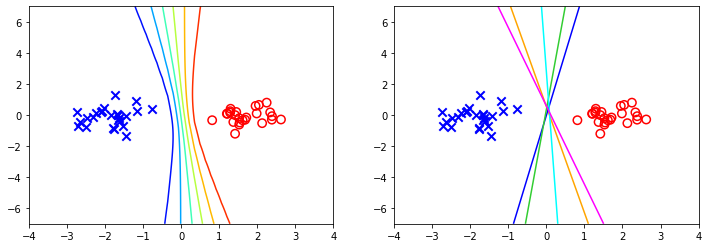

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from base_module import *
from classifier import VariationalClassifier

n_sample = 50

def make_blobs(n_sample):
    cls1 = np.random.normal(size=(n_sample // 2, 2), loc=(+1.8, 0), scale=.5)
    cls2 = np.random.normal(size=(n_sample // 2, 2), loc=(-1.8, 0), scale=.5)
    X = np.concatenate([cls1, cls2])
    return X, np.where(X[:, 0] > 0, 1, 0)


def plot_train_data(ax):
    N = n_sample // 2
    ax.scatter(*train_x[:N, :].T, marker='o', fc='none', ec='r', lw=1.5, s=70)
    ax.scatter(*train_x[N:, :].T, marker='x', lw=2, s=70, c='b')



# training & test data set
train_x, train_t = make_blobs(n_sample)
feature = Poly_Feature(degree=1)
X_train = feature.transform(train_x)

X, Y = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
X_test = np.array([X, Y]).reshape(2, -1).T
X_test = feature.transform(X_test)


'''Variational logistic regression'''
model = VariationalClassifier()
model.fit(X_train, train_t)
Z = model.predict(X_test)


# variational estimation data
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
plot_train_data(ax)
ax.contour(X, Y, Z.reshape(X.shape), levels=np.linspace(min(Z), max(Z), 8), cmap='jet')
plt.xlim(-4,4)


# plot posterior sample
ax = fig.add_subplot(122)
plot_train_data(ax)
colors = ['orange', 'blue', 'limegreen', 'cyan', 'magenta']
for c in colors:
    prob = model.posterior(X_test)
    ax.contour(X, Y, prob.reshape(X.shape), levels=1, colors=c)
plt.xlim(-4, 4)
plt.show()